# Підготовка даних

&emsp;Нам надані два набори даних пов’язані з червоним і білим варіантами португальського вина «Vinho Verde». Через проблеми конфіденційності та логістики доступні лише фізико-хімічні (вхідні) та сенсорні (вихідні) змінні (наприклад, немає даних про типи винограду, бренд вина, ціну продажу вина тощо).

&emsp;Метою нашої роботи є визначити, яка з моделей задач класифікації та регресії буде робити найкращі передбачення. Отож, почнемо з підготовки бібліотек, необхідних для нашої роботи:

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

results = []


&emsp;Переглянемо перші 10 рядків наших даних, щоб мати уявлення, із чим ми маємо справу та переконатися, що данні успішно зчитані з файлу:

In [131]:
redWine = pd.read_csv('winequality-red.csv', sep=';')
whiteWine = pd.read_csv('winequality-white.csv', sep=';')

wine = pd.concat([redWine, whiteWine])

wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


&emsp;&emsp;Щоб бути впевненим в подальших дослідженнях, переконуємося, що у всіх стопцях відсутні порожні значення:

In [132]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9 KB


&emsp;&emsp;З інформації вище, можемо визначити, що якість вин (quality) є дискретним типом даних, оскільки використовує обмеженний радіус чисел int64, у той щас як решта є неперервиними.

&emsp;Почнемо з простими порівняннями між білими та червоними винами. За діаграмою нижче, можемо спостерігати співвідношення між видами вин. Хороших, як і жахливих за якістю вин нещадно мало, їх тяжко помітити, але у співвідношенні можемо спостерігати, що білі вина в середньому кращі за якістю, ніж червоні.

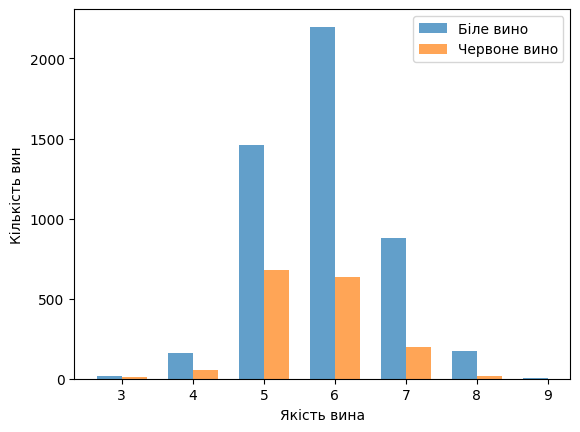

In [133]:
red_counts = redWine['quality'].value_counts().sort_index()
white_counts = whiteWine['quality'].value_counts().sort_index()

bar_width = 0.35

bar_positions_white = np.arange(len(white_counts))
bar_positions_red = np.arange(len(red_counts)) + bar_width

fig, ax = plt.subplots()

ax.bar(bar_positions_white, white_counts, label='Біле вино', width=bar_width, alpha=0.7)
ax.bar(bar_positions_red, red_counts, label='Червоне вино', width=bar_width, alpha=0.7)

plt.xlabel('Якість вина')
plt.ylabel('Кількість вин')
plt.xticks(bar_positions_white + bar_width / 2, [str(x) for x in range(3, 10)])
plt.legend()

plt.show()


&emsp;&emsp;Дослідимо зв'язок між змінними у наших данних через матрицю кореляції:

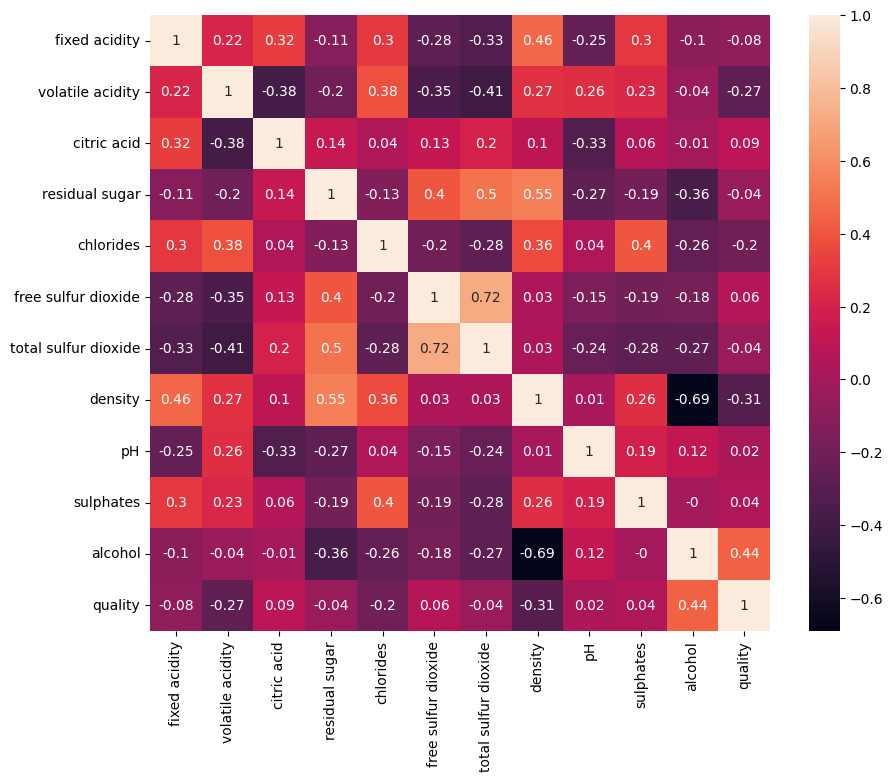

In [134]:
corr_mat_wine = wine.corr().round(2)
plt.figure(figsize = (10, 8))
plot = sns.heatmap(corr_mat_wine, annot = True)


Зробимо декілька поверхових висновків стосовно зображення вище:<br>
<ul>
    <li>Коефіцієнт 0.44 між якістю вина та вмістом алкоголя свідчить про помірну позитивну кореляцію між цими двома змінними. Тобто, зі зростанням вмісту алкоголю частіше спостерігається підвищення якості вина.</li>
    <li>Коефієнт 0.36 між вмістом якістю та вільним сульфатом вина також вказує на позитивний зв'язок між двома змінними.</li>
    <li>Найгірше на якість вина впливає резидуальний цукор та летюча кислотність з їх від'ємним відношенням -0.31 та -0.27 відповідно.</li>
</ul>

&emsp;&emsp;Наостанок, проведемо обробку даних. Поза кадром я спробував прибрати деякі окремі типи даних, які незначно впливають на якість вина, але на якість моделі це не повпливало. Логарифмування в нашому випадку я вважаю непотрібним, отже зробимо нормалізацію:

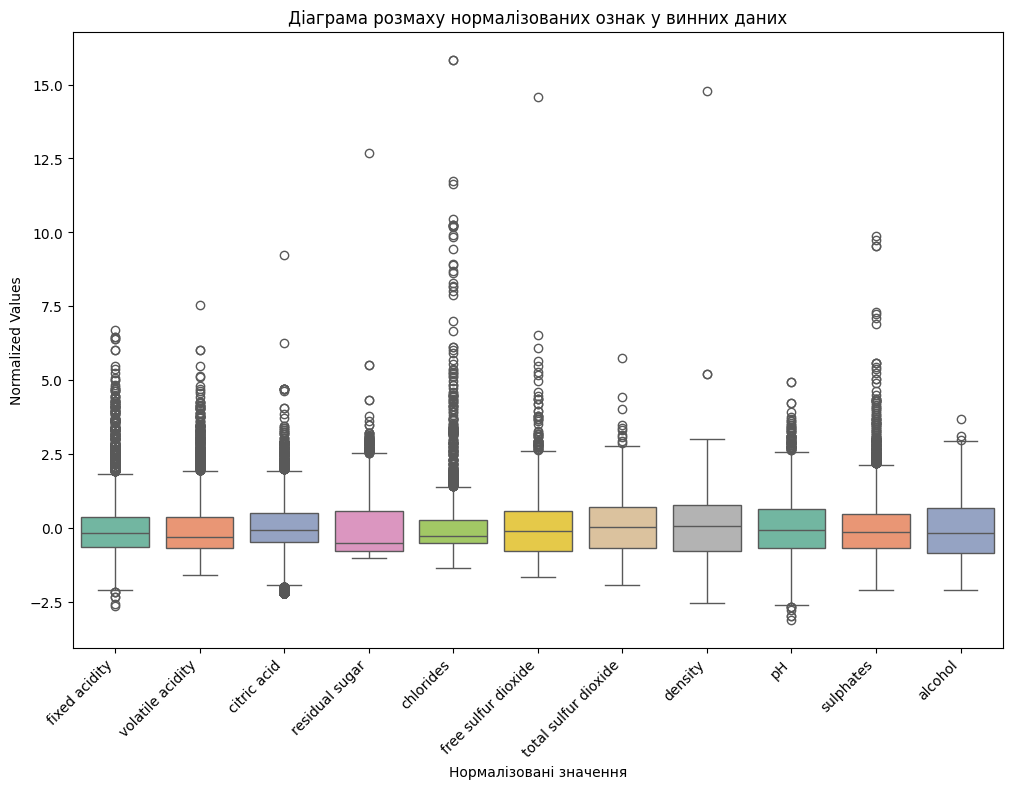

In [5]:
import seaborn as sns

redWine = pd.read_csv('winequality-red.csv', sep=';')
whiteWine = pd.read_csv('winequality-white.csv', sep=';')

wine = pd.concat([redWine, whiteWine])

input_columns = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

scaler = StandardScaler()

wine[input_columns] = scaler.fit_transform(wine[input_columns])

plt.figure(figsize=(12, 8))
sns.boxplot(data=wine[input_columns], palette='Set2')
plt.title('Діаграма розмаху нормалізованих ознак у винних даних')
plt.xlabel('Нормалізовані значення')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45, ha='right')
plt.show()


# Моделі

<h3>Лінійна регресія</h3>

&emsp;Всі данні успішно підготовлені, можемо бути впевненими, що ніякиї підводних каменів не має. Тому, наступним кроком ми приступаємо до навачання та оцінки моделей, і почнеми з лінійної регресії:

In [136]:
X = wine.drop('quality', axis=1) 
y = wine['quality']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = LinearRegression()

parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(model, parameters, cv=kf, scoring='neg_mean_squared_error')

grid.fit(X, y)

best_params = grid.best_params_

print("Найкращі параметри: ", best_params)

model = LinearRegression(**best_params)

train_res, test_res = [], []

for train_idx, test_idx in kf.split(X, y):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    
    y_train_preds, y_test_preds = model.predict(X_train), model.predict(X_test)
    
    train_error = np.round(mean_squared_error(y_train, y_train_preds), 2)
    test_error = np.round(mean_squared_error(y_test, y_test_preds), 2)
    
    train_res.append(train_error)
    test_res.append(test_error)

results.append({"method": "Лінійна регресія", "train_error": sum(train_res)/len(train_res), "test_error": sum(test_res)/len(test_res)})

print('Train errors: ', train_res)
print('Test errors: ', test_res)


Найкращі параметри:  {'copy_X': True, 'fit_intercept': True}
Train errors:  [0.54, 0.54, 0.54, 0.54, 0.54]
Test errors:  [0.55, 0.54, 0.53, 0.55, 0.54]


&emsp;&emsp;З отриманих результатів можна зробити виснвоок, що модель має приблизно однакові значення помилки на навчальних та тестових наборах, що може свідчити про те, що модель не страждає від перенавчання або недонавчання.

&emsp;&emsp;Ключовий аспект полягає в тому, що помилки на навчальних і тестових наборах приблизно рівні (в даному випадку, вони практично однакові). Це може означати, що модель є достатньо простою або, навпаки, що дані можуть бути надто простими для моделі, і вона не може адекватно наблизити їх.

<h3>Дерево рішень</h3>

&emsp;&emsp;Наступним кроком розглянемо дерево рішень. У дерев є додаткова властивість глибини, від якої може залежати якість моделі. Пропоную переглянути різницю між заданням глибин у дерев, тому почнемо без сітки параметрів:

In [137]:
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_tree = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=2,
    min_samples_split=10,
    min_samples_leaf=5
).fit(X_train, y_train)

y_pred_train = reg_tree.predict(X_train)
y_pred_test = reg_tree.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Помилка на навчальних наборах:", mse_train)
print('Помилка тестових даних:', mse_test)


Помилка на навчальних наборах: 0.5808403653952521
Помилка тестових даних: 0.5893611011213997


&emsp;&emsp;Спостерігаємо, що помилки поки що грубші, ніж при лінійній регресії. Але давайте спробуємо поексперементувати з глибинами:

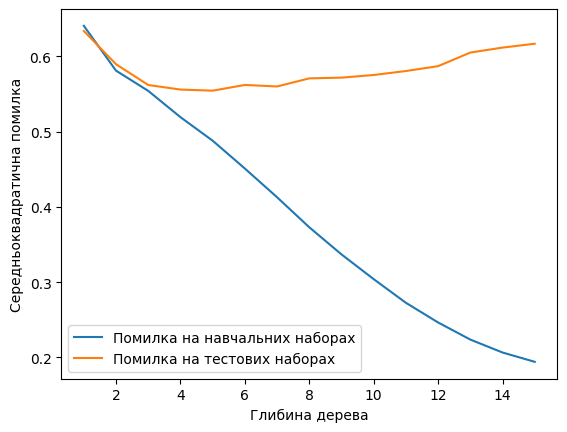

In [138]:
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_errors = []
test_errors = []
minTestError = 100
minTrainError = 100
depthWithMinError = 1

for depth in range(1, 16):
    reg_tree = DecisionTreeRegressor(
        criterion='squared_error',
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5
    ).fit(X_train, y_train)

    y_pred_train = reg_tree.predict(X_train)
    y_pred_test = reg_tree.predict(X_test)

    trainMSE = mean_squared_error(y_train, y_pred_train)
    testMSE = mean_squared_error(y_test, y_pred_test)

    train_errors.append(trainMSE)
    test_errors.append(testMSE)
    
    if testMSE < minTestError and trainMSE < minTrainError:
        minTestError = testMSE
        minTrainError = trainMSE
        depthWithMinError = depth


results.append({"method": "Дерево рішень", "train_error": minTrainError, "test_error": minTestError})

plt.plot(range(1, 16), train_errors, label='Помилка на навчальних наборах')
plt.plot(range(1, 16), test_errors, label='Помилка на тестових наборах')
plt.xlabel('Глибина дерева')
plt.ylabel('Середньоквадратична помилка')
plt.legend()
plt.show()


In [139]:
print("При глибині:", depthWithMinError)
print("Помилка на навчальних наборах:", minTrainError)
print("Помилка на тестових наборах:", minTestError)

При глибині: 5
Помилка на навчальних наборах: 0.4878398798548822
Помилка на тестових наборах: 0.5542661574325674


&emsp;&emsp;Дерева виявляються цікавішими та різноманітнішими, ніж лінійна регресія. При збільшенні глибини, згідно графіку, помилка на навчальних наборах значно падає, у той час як на тестових по-трохи зростає. "Золотою" глибиною виявилася п'ятірка (5). Давайте тепер спробуємо виявити найкращий результат дерев за допомогою сітки:

In [140]:
X = wine.drop('quality', axis=1) 
y = wine['quality']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = DecisionTreeRegressor()

parameters = {'criterion':['mse', 'friedman_mse', 'mae', 'poisson'],
              'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split':[2, 5, 10, 15, 20],
              'min_samples_leaf':[1, 2, 3, 4, 5]}

grid = GridSearchCV(model, parameters, cv=kf, scoring='neg_mean_squared_error')

grid.fit(X, y)

best_params = grid.best_params_

print("Найкращі параметри: ", best_params)

model = DecisionTreeRegressor(**best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Дерево рішень", "train_error": mse_train, "test_error": mse_test})

print('Помилка на тренувальних даних: ', mse_train)
print('Помилка на тестових наборах: ', mse_test)


Найкращі параметри:  {'criterion': 'poisson', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20}
Помилка на тренувальних даних:  0.4561511102688049
Помилка на тестових наборах:  0.5611670496175961


C:\Users\M_I\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2500 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\M_I\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\M_I\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

&emsp;Отож, на разі дерева рішень є лідерами.

<h3>Bagging</h3>

&emsp;Пропоную не відходити далеко від дерев рішень, та скористатися бегінгом (bagging). Основна ідея бегінга полягає в тому, щоб побудувати кілька однакових моделей на випадковій вибірці даних, а потім усереднити їх прогнози. Дані можуть повторюватися у різних моделях.

In [153]:
param_grid = {
    'n_estimators': [50, 80, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Найкращі параметри:', grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Бегінг", "train_error": mse_train, "test_error": mse_test})

print('Помилка на тренувальних даних:', mse_train)
print("Помилка на тестових наборах:", mse_test)


Найкращі параметри: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Помилка на тренувальних даних: 0.3588836831867713
Помилка на тестових наборах: 0.6185607153060371


&emsp;Мінімалістичне покращення виникає завдяки тому, що моделі у бегінгу навчаються на випадкових підмножинах даних, що робить їх більш незалежними. Шляхом обчислення середнього значення прогнозів моделей, помилка однієї моделі може бути скомпенсована більш вдалим прогнозом іншого. Це призводить до отримання більш стабільних і часто точних результатів.

<h3>Boosting</h3>

&emsp;Бустинг — це ще один "дерев'яний" алгоритм. Ідея бустінгу подібна до ідеї бегінгу у тому, що в обидвіх випадках формується ансамбль моделей, де кожна модель має невелику точність сама по собі, але разом вони дозволяють досягти високого результату.

&emsp;Втім, в той час як у бегінгу всі моделі будуються абсолютно незалежно одна від одної (на трохи різних даних, щоб різні учасники ансамблю не були абсолютно ідентичними), бустінг використовує відмінний підхід. Кожна наступна модель у бустінгу будується так, щоб скоригувати помилки всіх попередніх моделей. Бустінг отримав найбільшу популярність у поєднанні з деревами класифікації та регресії, що і підходить до нашого "винного" датасету.

&emsp;Пропоную розібрати найпоширеніший вид варіант бустінгу — градієнтний:

Найкращі параметри:  {'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror'}
Помилка на тренувальних даних:  0.07560754902083189
Помилка на тестових наборах:  0.37685291651310937


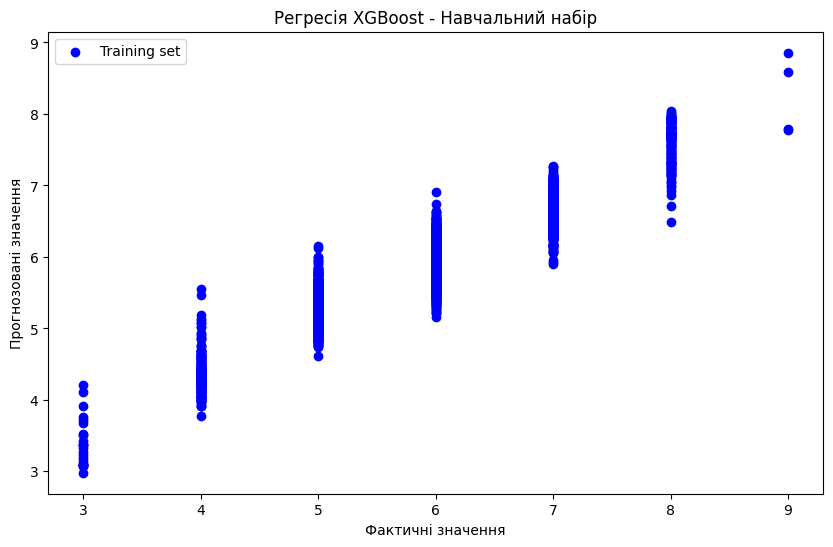

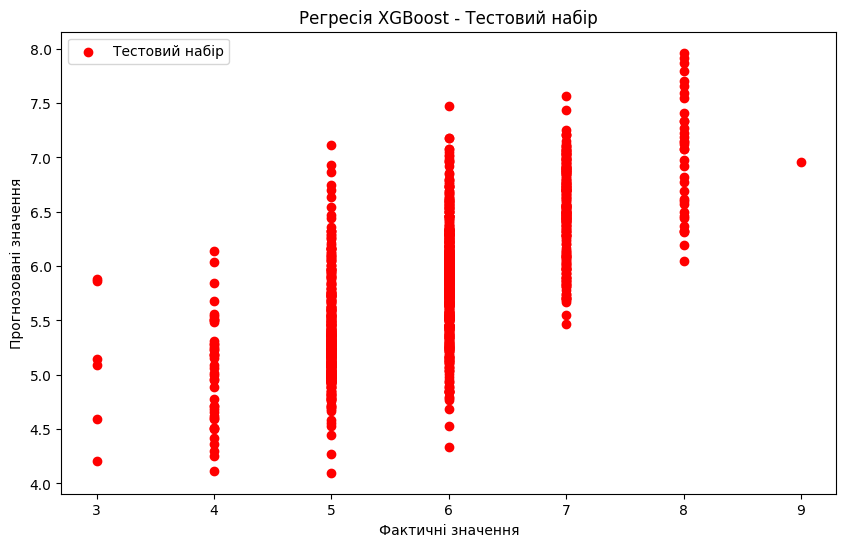

In [142]:
X = wine.drop('quality', axis=1) 
y = wine['quality']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = xgb.XGBRegressor()

parameters = {'objective':['reg:squarederror'],
              'n_estimators':[50, 100, 150, 200],
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
              'max_depth':[2, 3, 4, 5, 6],
              'min_child_weight':[1, 2, 3, 4, 5]}

grid = GridSearchCV(model, parameters, cv=kf, scoring='neg_mean_squared_error')

grid.fit(X, y)

best_params = grid.best_params_

print("Найкращі параметри: ", best_params)

model = xgb.XGBRegressor(**best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

results.append({"method": "Бустінг", "train_error": mse_train, "test_error": mse_test})

print('Помилка на тренувальних даних: ', mse_train)
print('Помилка на тестових наборах: ', mse_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, c='blue', label='Training set')
plt.xlabel('Фактичні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Регресія XGBoost - Навчальний набір')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='red', label='Тестовий набір')
plt.xlabel('Фактичні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Регресія XGBoost - Тестовий набір')
plt.legend()
plt.show()


&emsp;&emsp;Даний метод наразі є лідером, показавши чудові результати на тренуванні!

<h3>Метод опорних векторів</h3>

&emsp;Я би надав перевагу почати наше дослідження методу опорних векторів з лінійного методу, але оскільки повний розбір нашого датасету займає довгий час навіть без сітки, то ми скоротимо данні вдвічі, задавши <em>train_size = 0.5</em>.

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.5, random_state=42)

svm_model = SVR(kernel='linear')

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Лін. метод опорних векторів", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на навчальних наборах: 0.5474708271190121
Помилка на тестових наборах: 0.5581559260410148


&emsp;Результати, як ми бачимо, доволі помірні та майже нічим не відрізняються від досліджень із лінійною регресією. Знову взявши за основу цілий датасет, спробуємо поліноміальне ядро:

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
svm_model = SVR(kernel='poly')

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Поліном. метод опорних векторів", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на навчальних наборах: 0.514882280394557
Помилка на тестових наборах: 0.6185607153060371


&emsp;Та радіальне базисне ядро:

In [151]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10],
              'epsilon': [0.01, 0.1, 0.2, 0.5]}

svm_model = SVR(kernel='rbf')

grid_search = GridSearchCV(svm_model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_svm_model = SVR(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])

best_svm_model.fit(X_train, y_train)

y_pred_train = best_svm_model.predict(X_train)
y_pred_test = best_svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Метод RBF опорних векторів", "train_error": mse_train, "test_error": mse_test, "best_params": best_params})

print("Найкращі параметри:", best_params)
print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Найкращі параметри: {'C': 1, 'epsilon': 0.1, 'gamma': 1}
Помилка на навчальних наборах: 0.10775659280675404
Помилка на тестових наборах: 0.4348696209691574


&emsp;На жаль, лишень лінійний метод цієї моделі видає втішні результати, решта заставляє бажати кращого.

<h3>Нейромережа</h3>

&emsp;&emsp;На останок, я вирішив притягнути нейромережі до наших дослджень, а саме Keras. Вони мають певну перевагу над методами, що ми використовували до цього, а саме вони мають здатність виявляти складні залежності та автоматично вчитися ваги із навчальних даних, адаптуючись до особливостей конкретного набору даних.

&emsp;&emsp;Однак, вони потребують велику кількість данних для кращих результатів, що може погано зіграти з нашими даними.

Epoch 1/100
130/130 - 1s - loss: 6.7306 - val_loss: 1.7544 - 1s/epoch - 11ms/step
Epoch 2/100
130/130 - 0s - loss: 1.2879 - val_loss: 1.1786 - 295ms/epoch - 2ms/step
Epoch 3/100
130/130 - 0s - loss: 0.9239 - val_loss: 0.8441 - 267ms/epoch - 2ms/step
Epoch 4/100
130/130 - 0s - loss: 0.6883 - val_loss: 0.6249 - 321ms/epoch - 2ms/step
Epoch 5/100
130/130 - 0s - loss: 0.5707 - val_loss: 0.5392 - 321ms/epoch - 2ms/step
Epoch 6/100
130/130 - 0s - loss: 0.5255 - val_loss: 0.5300 - 314ms/epoch - 2ms/step
Epoch 7/100
130/130 - 0s - loss: 0.4967 - val_loss: 0.4869 - 264ms/epoch - 2ms/step
Epoch 8/100
130/130 - 0s - loss: 0.4858 - val_loss: 0.4745 - 265ms/epoch - 2ms/step
Epoch 9/100
130/130 - 0s - loss: 0.4815 - val_loss: 0.4863 - 294ms/epoch - 2ms/step
Epoch 10/100
130/130 - 0s - loss: 0.4773 - val_loss: 0.4774 - 287ms/epoch - 2ms/step
Epoch 11/100
130/130 - 0s - loss: 0.4661 - val_loss: 0.4600 - 239ms/epoch - 2ms/step
Epoch 12/100
130/130 - 0s - loss: 0.4645 - val_loss: 0.4755 - 320ms/epoch - 

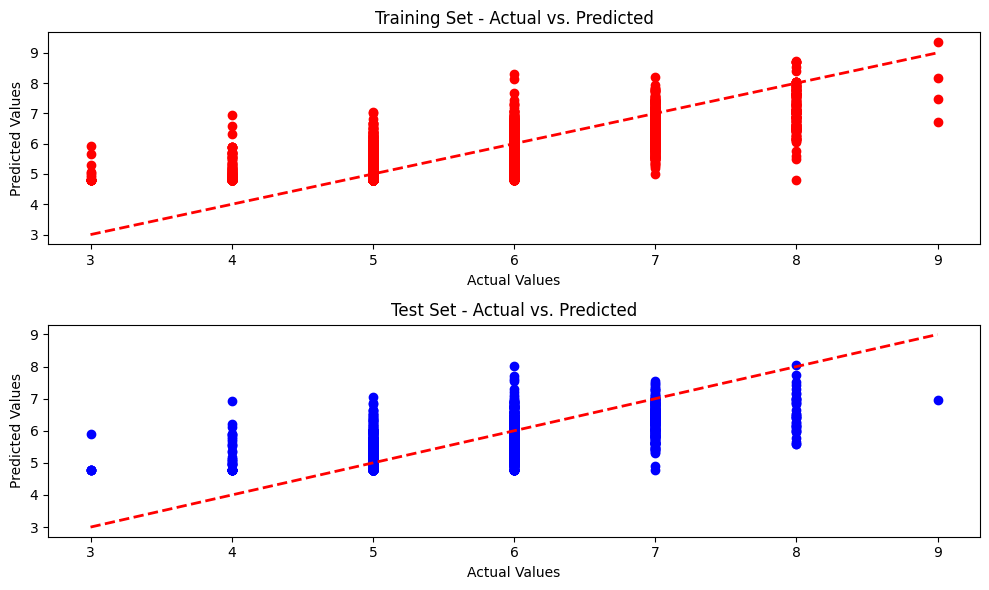

In [148]:
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.001, 0.01, 0.1]
mse_results = []

for learning_rate in learning_rates:
    model = create_model(learning_rate=learning_rate)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)
    
    y_pred_train = model.predict(X_train).flatten()
    y_pred_test = model.predict(X_test).flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    mse_results.append({"learning_rate": learning_rate, "train_error": mse_train, "test_error": mse_test})

best_result = min(mse_results, key=lambda x: x["test_error"])
best_learning_rate = best_result["learning_rate"]

final_model = create_model(learning_rate=best_learning_rate)

final_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

y_pred_train = final_model.predict(X_train).flatten()
y_pred_test = final_model.predict(X_test).flatten()

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Нейромережа Keras", "train_error": mse_train, "test_error": mse_test})


print("Найкращий темп навчання:", best_learning_rate)
print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(y_train, y_pred_train, color='red')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2)
plt.title('Training Set - Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(2, 1, 2)
plt.scatter(y_test, y_pred_test, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Test Set - Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


&emsp;&emsp;Нейромережі показали себе подібно деревам, тобто висока помилка на навчальних даних та низька на тренувальних (відносно яких вона перевершила звичайні дерева рішень). На жаль, бустінг нейромережі не змогли подолати.

# Висновок

&emsp;У нашому дослідженні ми використали кілька моделей для прогнозування якості вин Vinho Verde. Почали ми з лінійної регресії, яка показала дуже добрі результати і є найкращою моделю, якщо нашою метою є мінімізація різниці між тестовими та навчальними даними.

&emsp;Далі ми використали дерева рішень. Вони можуть бути використані, якщо нам припустиме збільшення різниці між тестовими та навчальними даними. Використання методу бегінгу покращило результати ще більше, підвищуючи стійкість та точність моделі. Застосування методу бустингу вразило ж найбільше: при вдалому підборі параметрів середньоквадратичною помилкою на тренувальних даних у нас виявилася цифра 0.07!

&emsp;Метод опорних векторів (SVM) виявився також непоганим методом, особливо при використанні лінійного або радіального ядра, де тренувальна точність є дуже високоб.

&emsp;Нейромережі, на жаль, у даному рейтингу пасуть задніх: точність у них непогана, але вони уступають своїм конкурентам.

&emsp;У підсумку, метод бустінгу є однозначним фаворитом у контексті даного дослідження, що продемонстровано на діаграмі нижче.

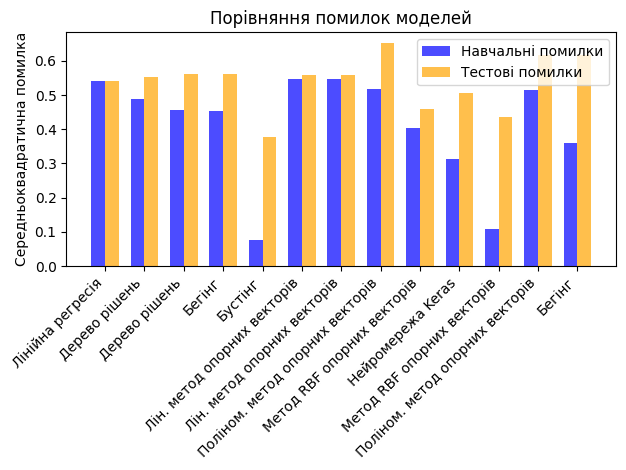

In [154]:
methods = [result['method'] for result in results]
train_errors = [result['train_error'] for result in results]
test_errors = [result['test_error'] for result in results]

width = 0.35  

x = np.arange(len(methods))  

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, train_errors, width, label='Навчальні помилки', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, test_errors, width, label='Тестові помилки', color='orange', alpha=0.7)

ax.set_ylabel("Середньоквадратична помилка")
ax.set_title("Порівняння помилок моделей")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right') 
ax.legend()

fig.tight_layout()

plt.show()


---
# <center> **Дякую за увагу!**</center>
---
